# Protein Ligant Prediction

## Data Set - Link and Node apo CSV files with ground_truth

In [3]:
import os
import pandas as pd
import random

def get_file_summary(file_path):
    data = pd.read_csv(file_path)
    summary = {
        "Number of Rows": len(data),
        "Number of Columns": len(data.columns)
    }
    return summary


apo_folder = 'apo'


node_files = [f for f in os.listdir(apo_folder) if f.endswith('_nodes.csv')]
link_files = [f for f in os.listdir(apo_folder) if f.endswith('_links.csv')]


if len(node_files) < 5 or len(link_files) < 5:
    print("Not enough files to select 5 pairs.")
else:
    
    selected_node_files = random.sample(node_files, 5)
    selected_link_files = [f.replace('_nodes.csv', '_links.csv') for f in selected_node_files]

    for node_file, link_file in zip(selected_node_files, selected_link_files):
        node_summary = get_file_summary(os.path.join(apo_folder, node_file))
        link_summary = get_file_summary(os.path.join(apo_folder, link_file))

        print(f"Node File: {node_file}, Summary: {node_summary}")
        print(f"Link File: {link_file}, Summary: {link_summary}")
        print("-" * 40)


Node File: 2QFO_B_nodes.csv, Summary: {'Number of Rows': 1626, 'Number of Columns': 41}
Link File: 2QFO_B_links.csv, Summary: {'Number of Rows': 11453, 'Number of Columns': 23}
----------------------------------------
Node File: 6HB0_A_nodes.csv, Summary: {'Number of Rows': 2266, 'Number of Columns': 41}
Link File: 6HB0_A_links.csv, Summary: {'Number of Rows': 16128, 'Number of Columns': 23}
----------------------------------------
Node File: 1SU4_A_nodes.csv, Summary: {'Number of Rows': 7670, 'Number of Columns': 41}
Link File: 1SU4_A_links.csv, Summary: {'Number of Rows': 55200, 'Number of Columns': 23}
----------------------------------------
Node File: 1CLL_A_nodes.csv, Summary: {'Number of Rows': 1085, 'Number of Columns': 41}
Link File: 1CLL_A_links.csv, Summary: {'Number of Rows': 7366, 'Number of Columns': 23}
----------------------------------------
Node File: 3CHE_A_nodes.csv, Summary: {'Number of Rows': 3066, 'Number of Columns': 41}
Link File: 3CHE_A_links.csv, Summary: {'N

## Processing of Data

- Removing of redundant columns
- Adding bidirectional and self links
- creating graph structures

In [11]:
import pandas as pd
import torch
from torch_geometric.data import Data
import os

def load_and_process_data(prefix):
    node_file = f'apo/{prefix}_nodes.csv'
    link_file = f'apo/{prefix}_links.csv'

    node_data = pd.read_csv(node_file)
    link_data = pd.read_csv(link_file)

    # Separate features and labels
    labels = node_data['ground_truth'].values
    features = node_data.drop(columns=['ground_truth'])

    node_features = features[['atom_type', 'residue_type', 'center_x', 'center_y', 'center_z', 'radius', 'voromqa_sas_potential', 'residue_mean_sas_potential', 'residue_sum_sas_potential', 'residue_size', 'sas_area', 'solvdir_x', 'solvdir_y', 'solvdir_z', 'voromqa_sas_energy', 'voromqa_depth', 'voromqa_score_a', 'voromqa_score_r', 'volume', 'volume_vdw', 'ufsr_a1', 'ufsr_a2', 'ufsr_c2', 'ufsr_c3', 'ev28', 'ev56']]
    link_features = link_data[['atom_index1', 'atom_index2', 'area', 'boundary', 'distance', 'voromqa_energy', 'seq_sep_class', 'covalent_bond', 'hbond']]

    # Create edge index
    edge_index = torch.tensor([link_features['atom_index1'].values, link_features['atom_index2'].values], dtype=torch.long)

    # Add self-links and bidirectional links
    self_links = torch.arange(0, len(node_features))
    edge_index = torch.cat([edge_index, torch.stack([self_links, self_links])], dim=1)
    edge_index = torch.cat([edge_index, edge_index[[1, 0], :]], dim=1)  # Add reverse direction

    # Convert node features and labels to tensors
    node_features_tensor = torch.tensor(node_features.values, dtype=torch.float)
    labels_tensor = torch.tensor(labels, dtype=torch.float)

    # Create graph data object
    data = Data(x=node_features_tensor, edge_index=edge_index, y=labels_tensor)

    return data


candidate_pairs_file = 'apo/candidate_pairs.txt'
candidate_pairs = pd.read_csv(candidate_pairs_file, delim_whitespace=True)


graphs = {}
for index, row in candidate_pairs.iterrows():
    prefix = f"{row['apo_pdb_id']}_{row['apo_chain_id']}"
    graphs[prefix] = load_and_process_data(prefix)



save_dir = 'saved_graphs'
os.makedirs(save_dir, exist_ok=True)


for prefix, graph in graphs.items():
    save_path = os.path.join(save_dir, f'{prefix}_graph.pt')
    torch.save(graph, save_path)

print(f"All graphs have been saved in the directory: {save_dir}")

/var/folders/x2/tczl0fb10n985z37f3f86l800000gn/T/ipykernel_1709/4012719769.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  edge_index = torch.tensor([link_features['atom_index1'].values, link_features['atom_index2'].values], dtype=torch.long)


All graphs have been saved in the directory: saved_graphs


# Representation of Created Graphs

In [12]:
import os
import torch
import random

def get_graph_summary(file_path):
    graph = torch.load(file_path)
    summary = {
        "Number of Nodes": graph.num_nodes,
        "Number of Edges": graph.num_edges,
        "Feature Vector Size per Node": graph.num_node_features
    }
    return summary


saved_graphs_folder = 'saved_graphs'


graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]


if len(graph_files) < 5:
    print("Not enough files to select 5 graphs.")
else:
  
    selected_graph_files = random.sample(graph_files, 5)

    for graph_file in selected_graph_files:
        graph_summary = get_graph_summary(os.path.join(saved_graphs_folder, graph_file))
        print(f"Graph File: {graph_file}, Summary: {graph_summary}")
        print("-" * 40)


Graph File: 3UGK_A_graph.pt, Summary: {'Number of Nodes': 2884, 'Number of Edges': 47148, 'Feature Vector Size per Node': 26}
----------------------------------------
Graph File: 3MN9_A_graph.pt, Summary: {'Number of Nodes': 2817, 'Number of Edges': 46020, 'Feature Vector Size per Node': 26}
----------------------------------------
Graph File: 1JBU_H_graph.pt, Summary: {'Number of Nodes': 1695, 'Number of Edges': 27112, 'Feature Vector Size per Node': 26}
----------------------------------------
Graph File: 1EX6_A_graph.pt, Summary: {'Number of Nodes': 1445, 'Number of Edges': 22992, 'Feature Vector Size per Node': 26}
----------------------------------------
Graph File: 1K3F_B_graph.pt, Summary: {'Number of Nodes': 1879, 'Number of Edges': 30412, 'Feature Vector Size per Node': 26}
----------------------------------------


# Visualization of a random created Protein Graph

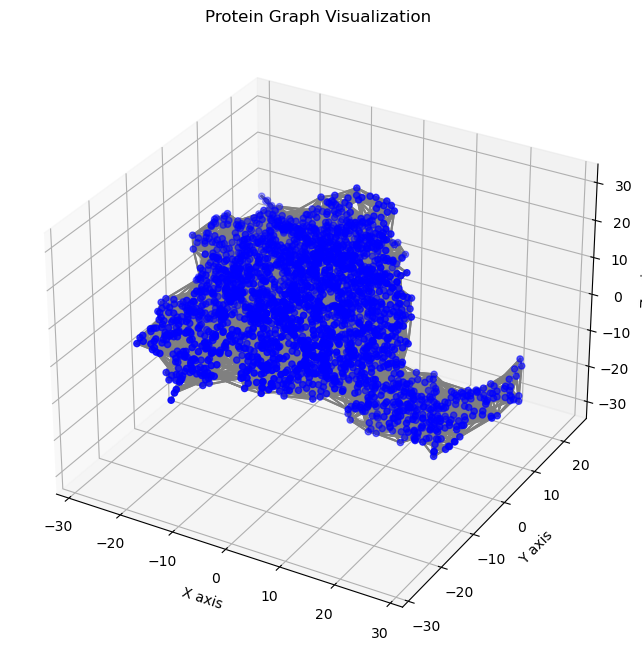

In [13]:
import os
import random
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_protein_graph(graph):
 
    pos = graph.x[:, 2:5]  


    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=20, c='blue')


    for edge in graph.edge_index.t():
        start, end = edge[0].item(), edge[1].item()
        xs, ys, zs = zip(pos[start], pos[end])
        ax.plot(xs, ys, zs, color='gray')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    plt.title("Protein Graph Visualization")
    plt.show()


saved_graphs_folder = 'saved_graphs'


graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]


selected_graph_file = random.choice(graph_files)


graph_path = os.path.join(saved_graphs_folder, selected_graph_file)
graph = torch.load(graph_path)


plot_protein_graph(graph)


# Training with a basic GCN Model (0.8 train 0.2 test)

Epoch 0, Loss: 12695.18071883859
Epoch 10, Loss: 239.01797481127156
Epoch 20, Loss: 1555.7152092213769
Epoch 30, Loss: 11.333218936202595
Epoch 40, Loss: 5.660765067466254
Epoch 50, Loss: 18.59444166676512
Epoch 60, Loss: 1.412205957671971
Epoch 70, Loss: 0.6750941658482968
Epoch 80, Loss: 0.6541836255962409
Epoch 90, Loss: 0.6505917756302843
Epoch 100, Loss: 0.6503311841233262
Epoch 110, Loss: 0.6504134055480216
Epoch 120, Loss: 0.6502696437743104
Epoch 130, Loss: 0.6504031876915867
Epoch 140, Loss: 0.6504009423904049
Epoch 150, Loss: 0.6503441935604058
Epoch 160, Loss: 0.6503064146319639
Epoch 170, Loss: 0.6503188037177892
Epoch 180, Loss: 0.6503633226005776
Epoch 190, Loss: 0.6503745172787638


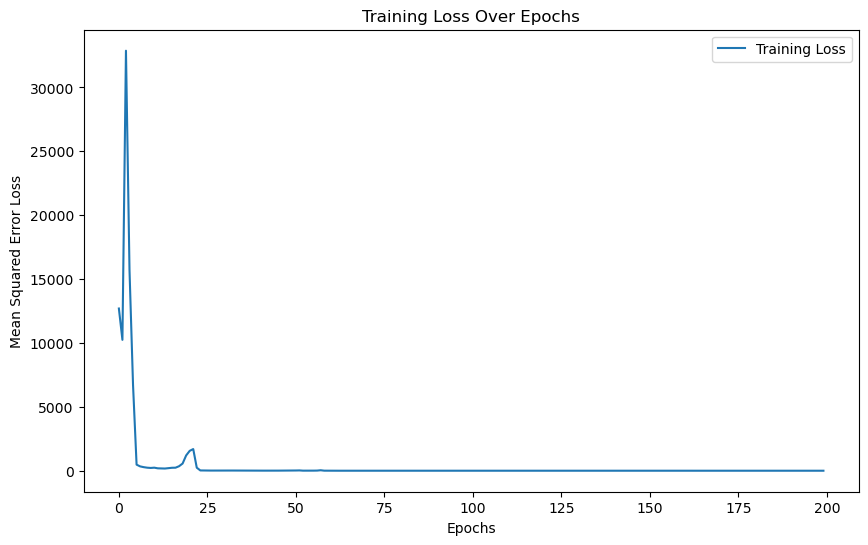

Test MSE: 0.651892791573818


In [14]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt


class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x


def load_graph_data():
    graph_files = os.listdir('saved_graphs')
    datasets = []

    for file in graph_files:
        data = torch.load(f'saved_graphs/{file}')
        datasets.append((data.x[:, :-1], data.x[:, -1], data.edge_index))  # Assuming the last column is ground truth

    return datasets

datasets = load_graph_data()


train_size = int(0.8 * len(datasets))
train_dataset = datasets[:train_size]
test_dataset = datasets[train_size:]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_features=datasets[0][0].size(1), hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()


model.train()
loss_values = [] 
for epoch in range(200):
    total_loss = 0
    for x, y, edge_index in train_dataset:
        x, y, edge_index = x.to(device), y.to(device), edge_index.to(device)
        optimizer.zero_grad()
        out = model(Data(x=x, edge_index=edge_index)).squeeze()
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    epoch_loss = total_loss / len(train_dataset)
    loss_values.append(epoch_loss)
    if epoch%10==0:
        print(f'Epoch {epoch}, Loss: {epoch_loss}')


plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


model.eval()
test_loss = 0
with torch.no_grad():
    for x, y, edge_index in test_dataset:
        x, y, edge_index = x.to(device), y.to(device), edge_index.to(device)
        pred = model(Data(x=x, edge_index=edge_index)).squeeze()
        test_loss += criterion(pred, y).item()
print(f'Test MSE: {test_loss / len(test_dataset)}')


# Training with a GAT Model with MAE Loss

Epoch: 0, Train Loss: 394.5303, Test Loss: 77.8268
Epoch: 10, Train Loss: 10.9452, Test Loss: 79.8016
Epoch: 20, Train Loss: 0.9428, Test Loss: 45.4738
Epoch: 30, Train Loss: 0.4091, Test Loss: 34.9675
Epoch: 40, Train Loss: 0.2642, Test Loss: 32.8299
Epoch: 50, Train Loss: 0.2571, Test Loss: 31.0024
Epoch: 60, Train Loss: 0.2930, Test Loss: 29.7057
Epoch: 70, Train Loss: 0.1549, Test Loss: 27.0914
Epoch: 80, Train Loss: 0.1451, Test Loss: 25.1389
Epoch: 90, Train Loss: 0.1459, Test Loss: 23.2184


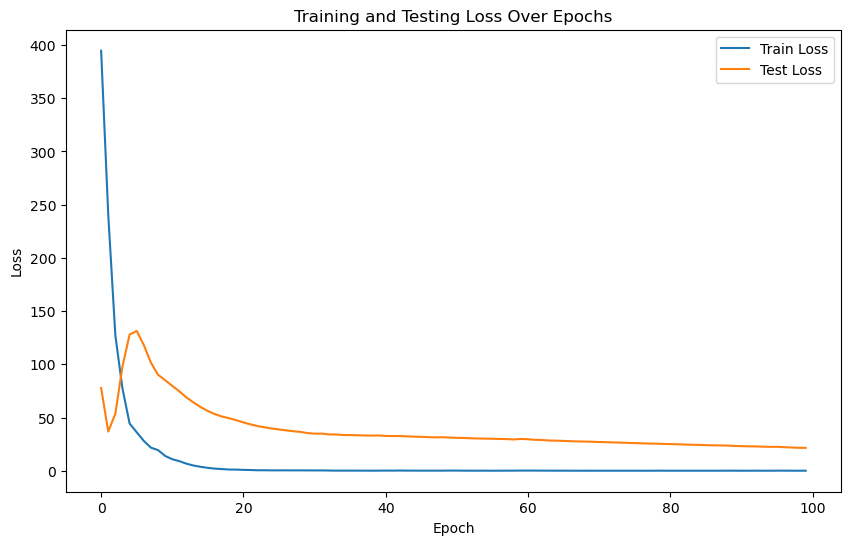

In [19]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import DataLoader
from torch.nn import L1Loss
import matplotlib.pyplot as plt

class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, 1)  

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x


saved_graphs_folder = 'saved_graphs'
graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]
datasets = [torch.load(os.path.join(saved_graphs_folder, f)) for f in graph_files]

train_size = int(0.8 * len(datasets))
train_dataset = datasets[:train_size]
test_dataset = datasets[train_size:]

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = GAT(num_features=datasets[0].num_node_features, hidden_channels=16).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = L1Loss()  # MAE loss


def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data).squeeze()
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


def test(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data).squeeze()
            total_loss += criterion(pred, data.y).item()
    return total_loss / len(loader)


train_losses = []
test_losses = []


for epoch in range(100):
    train_loss = train()
    test_loss = test(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if epoch%10==0:
        print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()


# Using Cross validation (k=5)

Fold 1, Test Loss: 85.0381
Fold 2, Test Loss: 0.1245
Fold 3, Test Loss: 263.1291
Fold 4, Test Loss: 0.9317
Fold 5, Test Loss: 10.7777
Average Test Loss: 72.0002


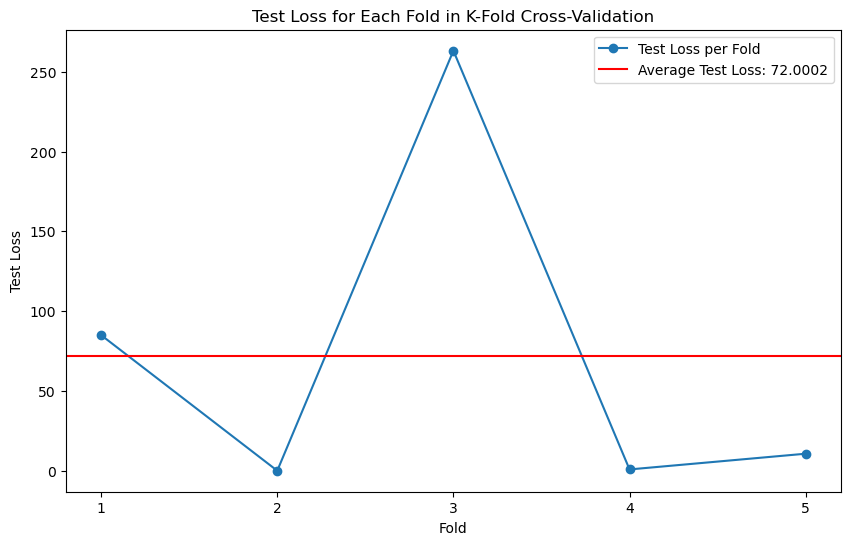

In [20]:
import torch
from torch_geometric.data import DataLoader
import numpy as np
from sklearn.model_selection import KFold

class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, 1)  

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x



def train_fold(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data).squeeze()
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def test_fold(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data).squeeze()
            loss = criterion(out, data.y)
            total_loss += loss.item()
    return total_loss / len(loader)



k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

datasets = [torch.load(os.path.join(saved_graphs_folder, f)) for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]
dataset_list = list(datasets)
test_losses = []

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset_list)):
    train_dataset = [dataset_list[i] for i in train_idx]
    test_dataset = [dataset_list[i] for i in test_idx]

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    model = GAT(num_features=train_dataset[0].num_node_features, hidden_channels=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    criterion = L1Loss()
    num_epochs=40
    for epoch in range(num_epochs):  # define num_epochs as needed
        train_fold(model, train_loader, optimizer, criterion)

    test_loss = test_fold(model, test_loader, criterion)
    test_losses.append(test_loss)
    print(f'Fold {fold + 1}, Test Loss: {test_loss:.4f}')

avg_test_loss = np.mean(test_losses)
print(f'Average Test Loss: {avg_test_loss:.4f}')


plt.figure(figsize=(10, 6))
plt.plot(range(1, k + 1), test_losses, marker='o', label='Test Loss per Fold')
plt.axhline(y=avg_test_loss, color='r', linestyle='-', label=f'Average Test Loss: {avg_test_loss:.4f}')
plt.xlabel('Fold')
plt.ylabel('Test Loss')
plt.title('Test Loss for Each Fold in K-Fold Cross-Validation')
plt.xticks(range(1, k + 1))
plt.legend()
plt.show()

# GNN Model with Cross Validation k=5

Fold 1, Test Loss: 1.4123
Fold 2, Test Loss: 2.2979
Fold 3, Test Loss: 11.4833
Fold 4, Test Loss: 0.5339
Fold 5, Test Loss: 5.8493
Average Test Loss: 4.3154


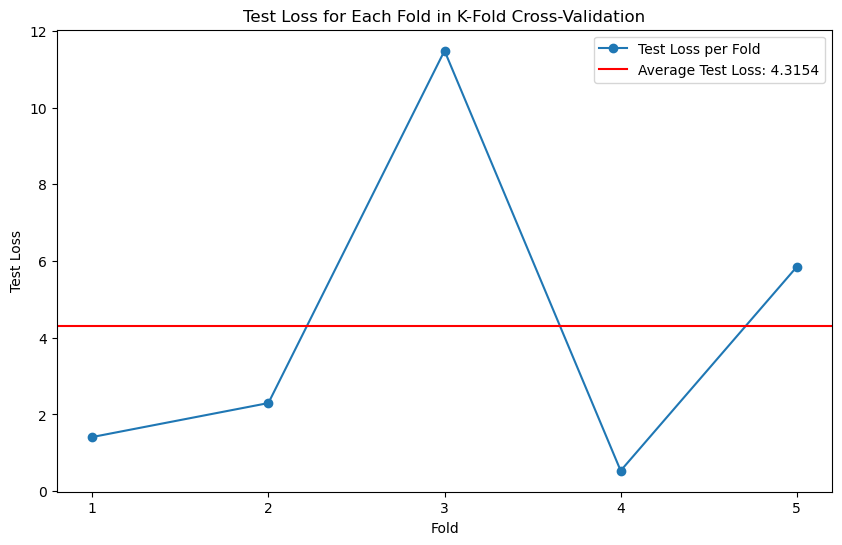

In [21]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from torch.nn import L1Loss
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np

class BasicGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(BasicGNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = GCNConv(hidden_channels, 1)  # Assuming a single target value

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.out(x, edge_index)
        return x.squeeze()

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item()
    return total_loss / len(loader)

# Prepare for k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
datasets = [torch.load(os.path.join(saved_graphs_folder, f)) for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]
dataset_list = list(datasets)

test_losses = []

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset_list)):
    train_dataset = [dataset_list[i] for i in train_idx]
    test_dataset = [dataset_list[i] for i in test_idx]
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    model = BasicGNN(num_features=train_dataset[0].num_node_features, hidden_channels=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = L1Loss()
    num_epochs = 30
    for epoch in range(num_epochs):  # define num_epochs as needed
        train_loss = train(model, train_loader, optimizer, criterion)
    
    test_loss = test(model, test_loader, criterion)
    test_losses.append(test_loss)
    print(f'Fold {fold + 1}, Test Loss: {test_loss:.4f}')

avg_test_loss = np.mean(test_losses)
print(f'Average Test Loss: {avg_test_loss:.4f}')

# Plotting test loss for each fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, k + 1), test_losses, marker='o', label='Test Loss per Fold')
plt.axhline(y=avg_test_loss, color='r', linestyle='-', label=f'Average Test Loss: {avg_test_loss:.4f}')
plt.xlabel('Fold')
plt.ylabel('Test Loss')
plt.title('Test Loss for Each Fold in K-Fold Cross-Validation')
plt.xticks(range(1, k + 1))
plt.legend()
plt.show()


# Atom to Residue Pooling

Create a new dataset which includes residue_index

In [22]:
import pandas as pd
import torch
from torch_geometric.data import Data
import os

def load_and_process_data(prefix):
    node_file = f'apo/{prefix}_nodes.csv'
    link_file = f'apo/{prefix}_links.csv'

    node_data = pd.read_csv(node_file)
    link_data = pd.read_csv(link_file)

    # Separate features and labels
    labels = node_data['ground_truth'].values
    features = node_data.drop(columns=['ground_truth'])

    node_features = features[['residue_index','atom_type', 'residue_type', 'center_x', 'center_y', 'center_z', 'radius', 'voromqa_sas_potential', 'residue_mean_sas_potential', 'residue_sum_sas_potential', 'residue_size', 'sas_area', 'solvdir_x', 'solvdir_y', 'solvdir_z', 'voromqa_sas_energy', 'voromqa_depth', 'voromqa_score_a', 'voromqa_score_r', 'volume', 'volume_vdw', 'ufsr_a1', 'ufsr_a2', 'ufsr_c2', 'ufsr_c3', 'ev28', 'ev56']]
    link_features = link_data[['atom_index1', 'atom_index2', 'area', 'boundary', 'distance', 'voromqa_energy', 'seq_sep_class', 'covalent_bond', 'hbond']]

    # Create edge index
    edge_index = torch.tensor([link_features['atom_index1'].values, link_features['atom_index2'].values], dtype=torch.long)

    # Add self-links and bidirectional links
    self_links = torch.arange(0, len(node_features))
    edge_index = torch.cat([edge_index, torch.stack([self_links, self_links])], dim=1)
    edge_index = torch.cat([edge_index, edge_index[[1, 0], :]], dim=1)  # Add reverse direction

    # Convert node features and labels to tensors
    node_features_tensor = torch.tensor(node_features.values, dtype=torch.float)
    labels_tensor = torch.tensor(labels, dtype=torch.float)

    # Create graph data object
    data = Data(x=node_features_tensor, edge_index=edge_index, y=labels_tensor)

    return data


candidate_pairs_file = 'apo/candidate_pairs.txt'
candidate_pairs = pd.read_csv(candidate_pairs_file, delim_whitespace=True)


graphs = {}
for index, row in candidate_pairs.iterrows():
    prefix = f"{row['apo_pdb_id']}_{row['apo_chain_id']}"
    graphs[prefix] = load_and_process_data(prefix)



save_dir = 'saved_graphs_wr'
os.makedirs(save_dir, exist_ok=True)


for prefix, graph in graphs.items():
    save_path = os.path.join(save_dir, f'{prefix}_graph.pt')
    torch.save(graph, save_path)

print(f"All graphs have been saved in the directory: {save_dir}")

All graphs have been saved in the directory: saved_graphs_wr


# GNN With Pooling (To Fix)

In [27]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader
from torch.nn import L1Loss
import matplotlib.pyplot as plt

class ResiduePoolingGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(ResiduePoolingGNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = torch.nn.Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        # Pooling at the residue level
        x = global_mean_pool(x, batch)

        x = self.out(x)
        return x.squeeze()

def process_data_for_pooling(graph):
    residue_index = graph.x[:, 0].long()  # Extract residue_index from the first column
    graph.batch = residue_index

    # Aggregate labels by residue
    unique_residues, residue_labels = torch.unique(residue_index, return_counts=False, return_inverse=True)
    aggregated_labels = torch.zeros(unique_residues.size(0), dtype=graph.y.dtype)
    for i, idx in enumerate(unique_residues):
        aggregated_labels[i] = graph.y[residue_index == idx].mean()  # Mean or other aggregation method

    graph.y = aggregated_labels
    graph.x = graph.x[:, 1:]  # Exclude the first column (residue_index)
    return graph

# Example data loading and processing
saved_graphs_folder = 'saved_graphs_wr'
datasets = [process_data_for_pooling(torch.load(os.path.join(saved_graphs_folder, f))) for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]

# Split datasets into train and test sets
train_size = int(0.8 * len(datasets))
train_dataset = datasets[:train_size]
test_dataset = datasets[train_size:]

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResiduePoolingGNN(num_features=train_dataset[0].x.size(1), hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = L1Loss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item()
    return total_loss / len(test_loader)

train_losses, test_losses = [], []
for epoch in range(20):  # Define the number of epochs
    train_loss = train()
    test_loss = test()
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Plotting the training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(test_losses, label='Test Loss', color='red', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


/Users/ariel.flahaut/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([36803])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (16) must match the size of tensor b (36803) at non-singleton dimension 0